# Guassian Anomaly Detection


### Multivariate Guaussian distribution is defined by two Parameters $\mu, \Sigma$. Where $\mu$ is a vector and $\Sigma$ is a Matrix:

### $$p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{n/2}} exp(-\frac{1}{2}(x- \mu)^T \Sigma^{-1}(x-\mu))$$

### I estimate my $\mu$ parameter using the formula:

### $$\mu = \frac{1}{m}\Sigma_{m}^i x^i $$

### An my $\Sigma$ parameter with:

### $$\Sigma = \frac{1}{m}\Sigma_{m}^i(x^i - \mu)(x^i - \mu)^T$$

### After estimating my parameters with my train data I will calculate the probability of my test data belonging to that same distribution. If $p(x)$ is small, I flag my observation as being an outlier. 

### Using this Guassian detection has the advantage of automatically capturing the corelation between the variables. However, it can be more computationally expensive with large values of n, because of the necessity to calculate the inverse of my matrix $\Sigma$. Another potential problem is that I need my number of observations m to be greater than my number of variables n. A good rule of thumb being $m \geq 10n$ to get a good estimation. Redundant features (linear dependency) that carry the same information can also pose a problem and should be excluded.



### I am using one of the datasets in the archive of Outlier detection webpage (available at: http://odds.cs.stonybrook.edu/#table1)

### Out of the many options I chose the thyroid dataset. This dataset has six continuous variables that represent several thyroid laboratories function tests. It also contains the label for outliers. They represent 2.5% of all observations.

### Both hyper and hypo thyroidism cases are labeled as outliers (Label = 1), normal cases are of course labeled as inliers (Label = 0)

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

In [2]:
#Loading the Matlab file using the loadmat command from scipy library
mat = loadmat('thyroid.mat')

In [3]:
#This loads the file as a dictionary in Python
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [4]:
#The data is stored in the X key (6 continuous variables) and the label in the y key
print(type(mat['X']), mat['X'].shape)
print(type(mat['y']), mat['y'].shape)

<class 'numpy.ndarray'> (3772, 6)
<class 'numpy.ndarray'> (3772, 1)


In [5]:
#The other keys are just metadata 
print(mat['__header__'])
print(mat['__version__'])
print(mat['__globals__'])

b'MATLAB 5.0 MAT-file, written by Octave 3.8.0, 2014-12-05 13:11:25 UTC'
1.0
[]


In [6]:
#Makign a pandas dataframe with my data from the dictionary and nameing the columns
columns = ['Label', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

t_df = pd.DataFrame(np.hstack((mat['y'], mat['X'])))

### Important: I am assuming the site from wich I downloaded kept the order of the original variables, found here: (https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/) in the file all.bpnames. 

### If not we could ahave a mismatch of laboratory values and labels (not crucial for this outlier detection example)

In [7]:
#Renaming the columns.
t_df.columns = ['Label', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

In [8]:
t_df.head(12)

,Label,TSH,T3,TT4,T4U,FTI,TBG
0,0.0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066
1,0.0,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770
2,0.0,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590
3,0.0,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066
4,0.0,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541
5,0.0,0.731183,0.000472,0.147059,0.196262,0.239437,0.198361
6,0.0,0.903226,0.000472,0.213472,0.294393,0.399061,0.195082
7,0.0,0.505376,0.003925,0.185009,0.196262,0.276995,0.177049
8,0.0,0.709677,0.002453,0.222960,0.198598,0.422535,0.127869
9,0.0,0.806452,0.000189,0.270398,0.285047,0.511737,0.155738


In [9]:
#Checking the integrity of the data:
t_df.shape

(3772, 7)

In [10]:
#Make sure I have no missing values:
t_df.isnull().sum()

Label    0
TSH      0
T3       0
TT4      0
T4U      0
FTI      0
TBG      0
dtype: int64

In [11]:
#Splitting Label and the data:
X,y = t_df.drop(columns=['Label']), t_df['Label']

In [12]:
#Reducing dimensionality using t-SNE for data visualization:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

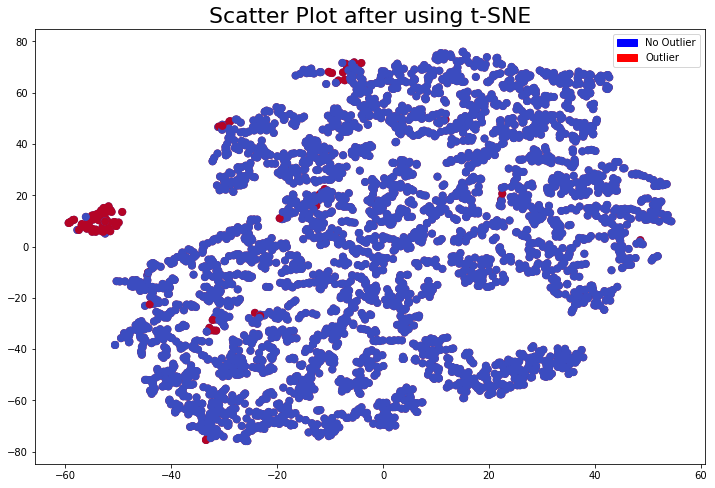

In [13]:
# Scatter Plot showing that we do have the outliers as a cluster

f, ax = plt.subplots(figsize=(12,8))

blue = mpatches.Patch(color='#0000FF', label='No Outlier')
red = mpatches.Patch(color='#FF0000', label='Outlier')

ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('Scatter Plot after using t-SNE', fontsize=22)


ax.legend(handles=[blue, red])

### Incidente of hyperthyroidism is 1.3% and of hypothyroidism is 0.1 to 2% according to the literature (Up to date Review). That means 1.4% to 3.3% if we sum them up.

### Taking the average of both values I will estimate my outliers as 2.35%


In [14]:
#Chnaging my y values because of the library ell
y = y.astype(np.int8)
y[y==1] = -1
y[y==0] = 1

In [15]:
#Making my train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify=y.values, random_state=42)

In [16]:
outlier_frac = 0.0235
ell = EllipticEnvelope(contamination=outlier_frac)
ell.fit(X_train)


EllipticEnvelope(assume_centered=False, contamination=0.0235, random_state=None,
                 store_precision=True, support_fraction=None)

In [17]:
# Binary prediction of normal vs. outlier
y_pred = ell.predict(X_test)
sum(y_pred == -1)  # Outlier points are predicted as -1

18

### Because my estimate based on the literature of 2.35% was so close to the true rate of 2.5% I expect a good result:

In [18]:
recall_score(y_test, y_pred, average='macro') 

0.8657036613272311

### What happens when I do not have a reliable source on how to estimate the rate of my outliers? 

### To solve this problem I will use a Grid Search to cover a range of 20 possible estimates going from 0% outliers to 5% outliers which is usually a good guess in most cases.

In [19]:
#Stratified K_fold
skf = StratifiedKFold(n_splits=5)
folds = list(skf.split(X_train, y_train))

In [20]:
#Doing my grid search
f1sc = make_scorer(f1_score)
ps = {"contamination": np.linspace(0.0, 0.05, 20)}
search = GridSearchCV(estimator=ell, param_grid=ps, scoring=f1sc, cv=folds)
search.fit(X_train, y_train)

GridSearchCV(cv=[(array([ 543,  588,  595, ..., 3014, 3015, 3016]),
                  array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  9...
             iid='warn', n_jobs=None,
             param_grid={'contamination': array([0.        , 0.00263158, 0.00526316, 0.00789474, 0.01052632,
       0.01315789, 0.01578947, 0.01842105, 0.02105263, 0.02368421,
       0.02631579, 0.02894737, 0.03157895, 0.03421053, 0.03684211,
       0.03947368, 0.04210526, 0.04473684, 0.04736842, 0.05      ])},
           

In [21]:
#Ordering by the best parameter results: 
table = pd.DataFrame(search.cv_results_)
table[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head()

,mean_test_score,std_test_score,params
8,0.991169,0.003811,{'contamination': 0.021052631578947368}
4,0.991065,0.002521,{'contamination': 0.010526315789473684}
5,0.991052,0.003044,{'contamination': 0.013157894736842105}
7,0.990847,0.003820,{'contamination': 0.018421052631578946}
9,0.990814,0.004042,{'contamination': 0.02368421052631579}


In [22]:
# Make predictions with our optimized envelope fit
optimal_ell = search.best_estimator_ 
y_pred = optimal_ell.predict(X_test)

In [23]:
# Printing the best contamination (outlier proportion) on the test set after a 5 fold cross validation. It
# matches the first row in the table above (params)
print(optimal_ell)

EllipticEnvelope(assume_centered=False, contamination=0.021052631578947368,
                 random_state=None, store_precision=True,
                 support_fraction=None)


In [24]:
#I got 16 outlier predictions (new Label = -1) against 739 inlier predictions (new Label = 1) 
type(y_pred), np.unique(y_pred, return_counts=True)

(numpy.ndarray, (array([-1,  1]), array([ 16, 739])))

In [25]:
#I got a slightly better recall score using Grid Search and Cross Validation 
recall_score(y_test, y_pred, average='macro') 

0.867062356979405

### After this exercise I applied the principles of Gaussian anomaly detection using a Scikitlearn library named EllipticEnvelope. I also applied two ways to estimate the best paramater to fit the model: Literature and Grid Search estimation; both similar good results